In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

#### Get the relevant training datasets and combine them to form the full training set with Proteins and Peptides

In [2]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
#print(train_proteins_df.shape)
#print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_proteins_df.head(10)

train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
#print(train_peptides_df.shape)
#print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_peptides_df.head(10)

pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del train_proteins_df, train_peptides_df
gc.collect()

train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
#print(train_clinical_data_df.shape)
#print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

full_training_data = pd.merge(pro_pep_join, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='inner')

del pro_pep_join, train_clinical_data_df
gc.collect()

full_training_data = full_training_data.drop(columns=['UniProt','Peptide','upd23b_clinical_state_on_medication','patient_id'])

#print(full_training_data.shape)
#full_training_data.head(10)

#### Remove the NaNs from the UPDRS test scores, using the mean from within the same group of UPDRS test scores, e.g. NaNs in updrs_4 are filled with mean of updrs_4

In [3]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

list_of_updrs_tests = full_training_data_melted.updrs_test.unique()

temp_df = full_training_data_melted.groupby(['updrs_test']).agg(visit_month_per_patient=('visit_id', 'count')
                                                      , mean_updrs_test_score=('updrs_test_score', 'mean') ).reset_index(level=['updrs_test'])

for i in range(len(list_of_updrs_tests)):
    #print(list_of_updrs_tests[i])
    updrs_test_mean = full_training_data[list_of_updrs_tests[i]].mean()
    #print(updrs_test_mean)
    full_training_data.fillna({list_of_updrs_tests[i]:updrs_test_mean}, inplace=True)

#### Combine all UPDRS scores are one column and creating categorical column of UPDRS tests

In [4]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

#print(full_training_data_melted.updrs_test_score.unique())
#print(full_training_data_melted.visit_month.unique())

#full_training_data_melted[full_training_data_melted['visit_id']=='55_0']

#### Check for NaNs

In [5]:
full_training_data_melted.isna().sum()

visit_id            0
visit_month         0
NPX                 0
PeptideAbundance    0
updrs_test          0
updrs_test_score    0
dtype: int64

#### Proceed to create a train-test split on the Training dataset, to test out the accuracy of the developed models

<AxesSubplot:>

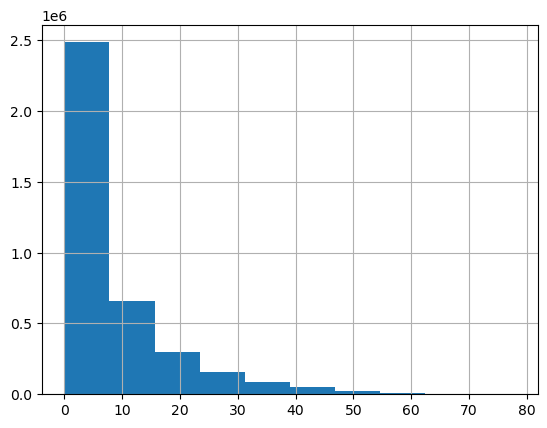

In [16]:
#full_training_data_melted[['updrs_test_score','PeptideAbundance','NPX','group_key']].corr()
full_training_data_melted['updrs_test_score'].hist()

<AxesSubplot:>

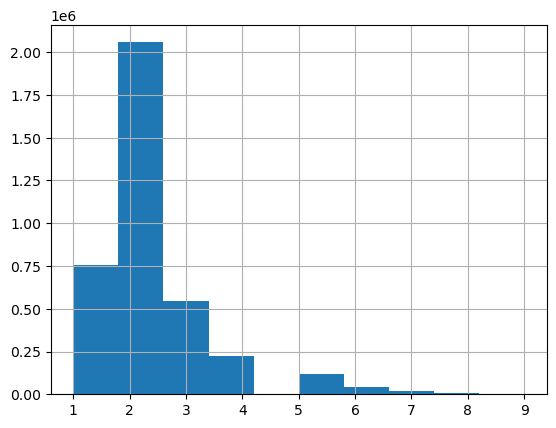

In [6]:
full_training_data_melted['updrs_score_category'] = pd.cut(full_training_data_melted['updrs_test_score'],
                                                          bins=[-np.inf, 0., 10., 20., 30., 40., 50., 60., 70., 80., np.inf],
                                                          labels=[1,2,3,4,5,6,7,8,9,10])

full_training_data_melted['updrs_score_category'].hist()

#### Check if there are any NaNs in the created bins, there shouldn't be any

In [8]:
full_training_data_melted['updrs_score_category'].unique()
#full_training_data_melted[full_training_data_melted['updrs_score_category'].isna()]
#full_training_data_melted[full_training_data_melted['updrs_test_score'] < 0]

[2, 3, 1, 5, 4, 6, 7, 8, 9]
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(full_training_data_melted, full_training_data_melted['updrs_score_category']):
    strat_train_set = full_training_data_melted.loc[train_index]
    strat_test_set = full_training_data_melted.loc[test_index]

#### Now, let's verify the percentage distribution of the data in the train and test splits, they should be very close

In [10]:
strat_test_set['updrs_score_category'].value_counts()/len(strat_test_set)

2     0.546203
1     0.201293
3     0.144421
4     0.058847
5     0.030969
6     0.011998
7     0.004732
8     0.001306
9     0.000232
10    0.000000
Name: updrs_score_category, dtype: float64

In [11]:
strat_train_set['updrs_score_category'].value_counts()/len(strat_train_set)

2     0.546202
1     0.201293
3     0.144421
4     0.058847
5     0.030969
6     0.011997
7     0.004731
8     0.001307
9     0.000232
10    0.000000
Name: updrs_score_category, dtype: float64

#### Get rid of the unwanted column which was created to assist in the splitting process

In [8]:
strat_train_set = strat_train_set.drop(columns=['updrs_score_category'])
strat_test_set = strat_test_set.drop(columns=['updrs_score_category'])
#strat_train_set.head(10)

#### Now let us separate the labels and numeric, categorical attributes so that we can build the scikit learn pipelines

In [9]:
strat_train_set_wo_labels = strat_train_set.drop('updrs_test_score', axis=1)
strat_train_set_labels = strat_train_set['updrs_test_score'].copy()
strat_train_set_numeric = strat_train_set_wo_labels.drop(columns=['visit_id','visit_month','updrs_test'])
strat_train_set_cat = strat_train_set_wo_labels[['visit_month','updrs_test']]

strat_test_set_wo_labels = strat_test_set.drop('updrs_test_score', axis=1)
strat_test_set_labels = strat_test_set['updrs_test_score'].copy()

del full_training_data, full_training_data_melted
gc.collect()

69

In [23]:
numeric_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])

numeric_attributes = list(strat_train_set_numeric)
categorical_attributes = list(strat_train_set_cat)

full_pipeline = ColumnTransformer([
    ('num', numeric_pipeline, numeric_attributes),
    ('cat', OneHotEncoder(), categorical_attributes)
])

strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set_wo_labels)
strat_test_set_prepared = full_pipeline.fit_transform(strat_test_set_wo_labels)

#### Train the Linear Regression model

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg_model = lin_reg.fit(strat_train_set_prepared, strat_train_set_labels)

### Testing the RMSE
#### RMSE <= 0.75 : Very good accuracy | 0.75 < RMSE <= 1.0 : Good accuracy

#### First on train data (train split from the full training dataset)

In [12]:
train_df_predictions = lin_reg_model.predict(strat_train_set_prepared)
mse = mean_squared_error(strat_train_set_labels, train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

8.439416662701587


#### 2nd on test data (test split from the full training dataset)

In [13]:
test_df_predictions = lin_reg_model.predict(strat_test_set_prepared)
mse = mean_squared_error(strat_test_set_labels, test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

8.429213893643048


In [12]:
import joblib

joblib.dump(lin_reg_model, '/kaggle/working/lin_reg_model.pkl')

['/kaggle/working/lin_reg_model.pkl']

In [14]:
import joblib

lin_reg_model = joblib.load('/kaggle/working/lin_reg_model.pkl')
#df_predictions = pd.DataFrame(lin_reg_model.predict(strat_train_set_prepared),columns=['rating'])
#print(df_predictions.shape)
temp = strat_train_set_wo_labels[['visit_id','visit_month','updrs_test']]
#print(temp.shape)
temp['prediction_id'] = temp['visit_id'] + '_' + temp['updrs_test'] + '_plus_' + temp['visit_month'].map(str) + '_months'
result = pd.DataFrame(lin_reg_model.predict(strat_train_set_prepared),columns=['rating'])
result['prediction_id'] = temp['prediction_id']
#temp[temp['visit_id'] == '55_0'].head(10)
final_result = result[['prediction_id','rating']]
final_result.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,prediction_id,rating
0,55_0_updrs_1_plus_0_months,0.064569
1,55_0_updrs_1_plus_0_months,6.361453
2,55_0_updrs_1_plus_0_months,1.498667
3,55_0_updrs_1_plus_0_months,1.744414
4,55_0_updrs_1_plus_0_months,8.746958
5,55_0_updrs_1_plus_0_months,1.497239
6,55_0_updrs_1_plus_0_months,2.405552
7,55_0_updrs_1_plus_0_months,16.806558
8,55_0_updrs_1_plus_0_months,17.714129
9,55_0_updrs_1_plus_0_months,3.279009


In [15]:
final_result[final_result['rating'].isna()].head(10)

,prediction_id,rating


In [18]:
df_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
#print(train_proteins_df.shape)
#print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
df_proteins.head(10)

df_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
#print(train_peptides_df.shape)
#print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
df_peptides.head(10)

pro_pep_join = pd.merge(df_proteins, df_peptides, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del df_proteins, df_peptides
gc.collect()

df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')
#print(train_clinical_data_df.shape)
#print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

full_test_data = pd.merge(pro_pep_join, df, on=['patient_id','visit_id','visit_month'], how='inner')

full_test_data.head(10)

,visit_id,visit_month,patient_id,UniProt,NPX,group_key_x,Peptide,PeptideAbundance,group_key_y,updrs_test,row_id,group_key
0,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.3,0,updrs_1,50423_0_updrs_1,0
1,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.3,0,updrs_2,50423_0_updrs_2,0
2,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.3,0,updrs_3,50423_0_updrs_3,0
3,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.3,0,updrs_4,50423_0_updrs_4,0
4,50423_0,0,50423,O00391,33127.9,0,NEQEQPLGQWHLS,10901.6,0,updrs_1,50423_0_updrs_1,0
5,50423_0,0,50423,O00391,33127.9,0,NEQEQPLGQWHLS,10901.6,0,updrs_2,50423_0_updrs_2,0
6,50423_0,0,50423,O00391,33127.9,0,NEQEQPLGQWHLS,10901.6,0,updrs_3,50423_0_updrs_3,0
7,50423_0,0,50423,O00391,33127.9,0,NEQEQPLGQWHLS,10901.6,0,updrs_4,50423_0_updrs_4,0
8,50423_0,0,50423,O00533,490742.0,0,GNPEPTFSWTK,51499.4,0,updrs_1,50423_0_updrs_1,0
9,50423_0,0,50423,O00533,490742.0,0,GNPEPTFSWTK,51499.4,0,updrs_2,50423_0_updrs_2,0


In [19]:
full_test_data = full_test_data[['visit_id','visit_month','NPX','PeptideAbundance','updrs_test']]
    
full_test_data = full_test_data.drop_duplicates()

"""full_df_numeric = full_test_data.drop(columns=['visit_id','visit_month','updrs_test'])
full_df_cat = full_test_data[['visit_month','updrs_test']]

numeric_pipeline = Pipeline([('standard_scaler', StandardScaler())])

numeric_attributes = list(full_df_numeric)
categorical_attributes = list(full_df_cat)

full_pipeline = ColumnTransformer([
    ('num', numeric_pipeline, numeric_attributes),
    ('cat', OneHotEncoder(), categorical_attributes)
])"""

In [24]:
df_prepared = full_pipeline.transform(full_test_data)

In [25]:
df_prepared.shape

(8228, 21)

In [26]:
temp = full_test_data[['visit_id','visit_month','updrs_test']]
print(temp.shape)
temp['prediction_id'] = temp['visit_id'] + '_' + temp['updrs_test'] + '_plus_' + temp['visit_month'].map(str) + '_months'
result = pd.DataFrame(lin_reg_model.predict(df_prepared),columns=['rating'])
result['prediction_id'] = temp['prediction_id']
final_result = result[['prediction_id','rating']]

(8228, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
def get_predictions(df, df_proteins, df_peptides, model, sklearn_pipeline):
    pro_pep_join = pd.merge(df_proteins, df_peptides, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')
    del df_proteins, df_peptides
    gc.collect()
    full_df = pd.merge(pro_pep_join, df, on=['patient_id','visit_id','visit_month'], how='inner')
    print(full_df.head(10))
    
    #full_df = full_df.drop(columns=['UniProt','Peptide','patient_id','group_key_x','group_key_y','group_key','row_id'])
    full_df = full_df[['visit_id','visit_month','NPX','PeptideAbundance','updrs_test']]
    full_df = full_df.drop_duplicates()

    df_prepared = sklearn_pipeline.transform(full_df)
    
    temp = full_df[['visit_id','visit_month','updrs_test']]
    print(temp.shape)
    temp['prediction_id'] = temp['visit_id'] + '_' + temp['updrs_test'] + '_plus_' + temp['visit_month'].map(str) + '_months'
    result = pd.DataFrame(model.predict(df_prepared),columns=['rating'])
    result['prediction_id'] = temp['prediction_id']
    final_result = result[['prediction_id','rating']]
    
    return final_result

In [28]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    result = get_predictions(test, test_proteins, test_peptides, lin_reg_model, full_pipeline)
    env.predict(result)
    
result.to_csv('/kaggle/working/submission.csv'
              , header=True, index=False)

Exception: You can only call `make_env()` once.